# Classify simulated context and measured EEG

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from psifr import fr
from cymr import parameters
from cymr import network
from cymr import cmr

from cfr import task
from cfr import decode
from cfr import framework

cfr_dir = Path(os.environ['CFR_RESULTS'])
fit_dir = Path(os.environ['CFR_FITS'])
fig_dir = Path(os.environ['CFR_FIGURES'])

model_name = 'cmrs_fcf-loc-cat-use_sl-B_enc-B_rec_fix-B_rec_cat1-B_rec_use1'
sublayer = 'use'
model_dir = fit_dir / model_name
fig_dir = Path(os.environ['CFR_FIGURES']) / 'sim3'
fig_dir.mkdir(exist_ok=True)
eeg_dir = cfr_dir / 'eeg' / 'study_patterns' / 'export'

## Load events included in EEG data

In [2]:
# load full events
data = task.read_study_recall(cfr_dir / 'cfr_eeg_mixed.csv')
study = fr.filter_data(data, trial_type='study').reset_index()
study = decode.mark_included_eeg_events(eeg_dir)

## Record model states

In [3]:
# set up simulation
subj_param = framework.read_fit_param(model_dir / 'fit.csv')
fit = pd.read_csv(model_dir / 'fit.csv', index_col=0)
param_def = parameters.read_json(model_dir / 'parameters.json')
patterns = network.load_patterns(cfr_dir / 'cfr_patterns.hdf5')

In [4]:
# record network states
model = cmr.CMR()
state = model.record(
    study, {}, subj_param, param_def=param_def, patterns=patterns, include=['c', 'c_in']
)
net = state[0]
c = np.vstack([s.c[net.get_slice('c', sublayer, 'item')] for s in state])
c_in = np.vstack([s.c_in[net.get_slice('c', sublayer, 'item')] for s in state])

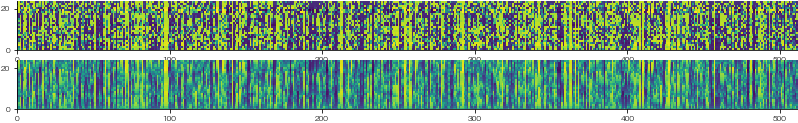

In [5]:
# display an example list
s1 = fr.filter_data(study, subjects=1, lists=2)
fig, ax = plt.subplots(figsize=(14, 2))
ax[0].pcolor(c_in[s1.index]);
ax[1].pcolor(c[s1.index]);

## Run decoding

In [6]:
results_list = []
for subject, trials in study.query('include').groupby('subject'):
    print(subject)
    context = c[trials.index]
    evidence = decode.classify_patterns(
        trials, context, normalization='range', clf='plogreg', C=0.1
    )
    evidence.index = trials.index
    subj_results = pd.concat([trials, evidence], axis=1)
    results_list.append(subj_results)
results = pd.concat(results_list, axis=0)

1
2
3
5
8
11
16
18
22
23
24
25
27
28
29
31
32
33
34
35
37
38
40
41
42
43
44
45
46


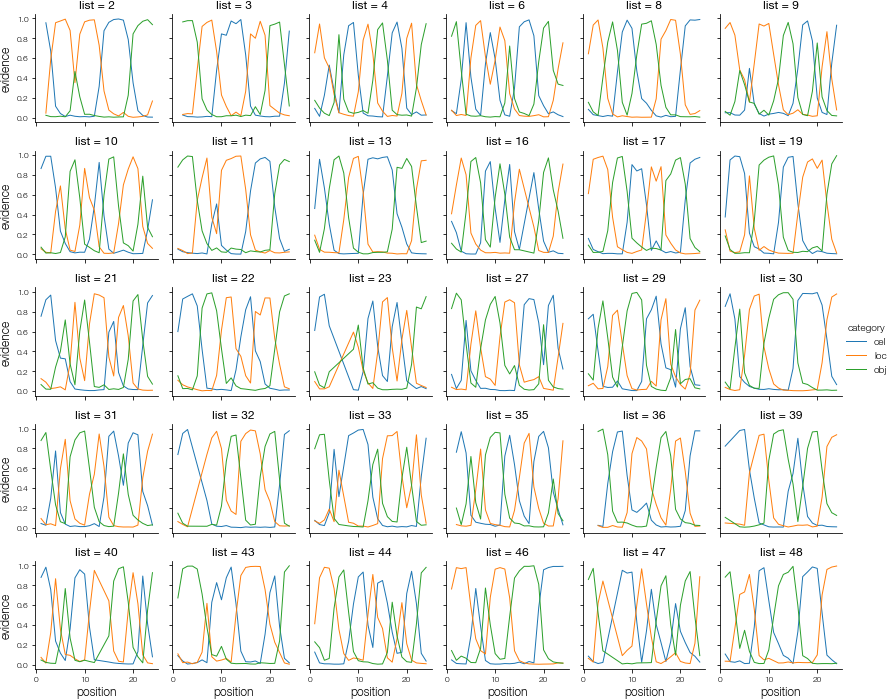

In [7]:
ml = pd.melt(
    fr.filter_data(results, subjects=1),
    id_vars=['subject', 'list', 'position', 'trial_type'],
    value_vars=['cel', 'loc', 'obj'],
    var_name='category',
    value_name='evidence',
)
sns.relplot(
    data=ml,
    kind='line',
    x='position',
    y='evidence',
    hue='category',
    col='list',
    col_wrap=6,
    height=2,
);

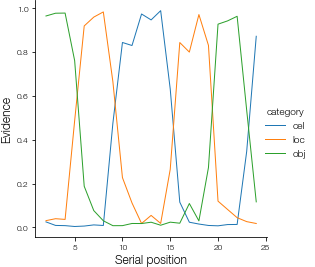

In [8]:
g = sns.relplot(
    data=ml.loc[ml['list'] == 3],
    kind='line',
    x='position',
    y='evidence',
    hue='category',
    height=4,
)
g.set(ylabel='Evidence', xlabel='Serial position');
g.savefig(fig_dir / 'sample_evidence.pdf')

## Context decoding by train position

In [9]:
# get study events, excluding the first blocks where previous 
# and baseline categories are undefined
included = results.query('block > 1 and trial_type == "study"')

# reorganize classifier evidence by block category (curr, prev, base)
labeled = decode.label_evidence(included)
labeled['subject'] = included['subject']
labeled['block_pos'] = included['block_pos']

# get average evidence and event counts
block_pos = labeled.groupby(['subject', 'block_pos'])
m = block_pos[['curr', 'prev', 'base']].mean()
m['n'] = block_pos['curr'].count()
m.head(6)

curr      prev      base    n
subject block_pos                                   
1       1          0.398570  0.523969  0.036891  191
        2          0.800542  0.181483  0.023194  191
        3          0.926260  0.077363  0.019969  122
        4          0.961617  0.049207  0.016931   79
        5          0.964907  0.039576  0.024845   20
        6          0.977465  0.017209  0.031297   12

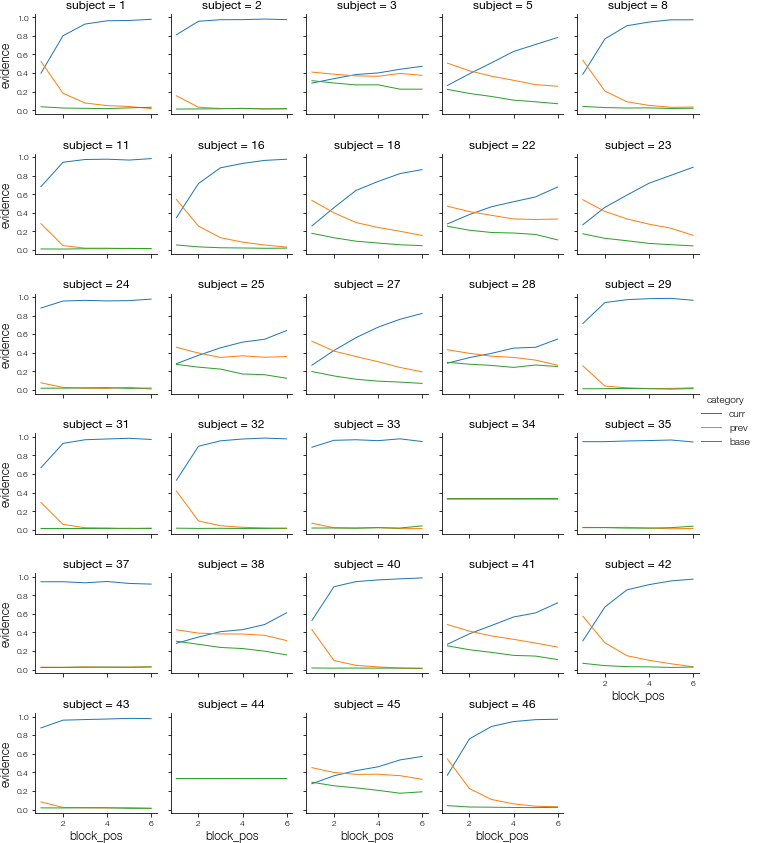

In [10]:
ml = pd.melt(
    m.reset_index(), 
    id_vars=['subject', 'block_pos'], 
    value_vars=['curr', 'prev', 'base'], 
    var_name='category', value_name='evidence',
)
sns.relplot(
    data=ml, 
    x='block_pos', 
    y='evidence', 
    hue='category', 
    col='subject', 
    col_wrap=5,
    kind='line',
    height=2,
);

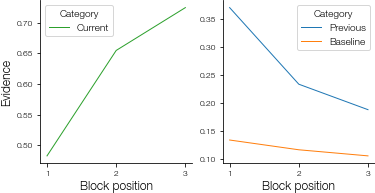

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ml['Category'] = ml['category'].map({'curr': 'Current', 'prev': 'Previous', 'base': 'Baseline'})
h = sns.lineplot(
    data=ml.query('category == "curr" and block_pos <= 3'), 
    x='block_pos', 
    y='evidence',
    hue='Category',
    palette=['C2'],
    ci=None,
    ax=ax[0]
)
sns.lineplot(
    data=ml.query('category != "curr" and block_pos <= 3'), 
    x='block_pos', 
    y='evidence',
    hue='Category',
    palette=['C0', 'C1'],
    ci=None,
    ax=ax[1]
)
# ax[0].legend()
ax[0].set(ylabel='Evidence', xlabel='Block position', xticks=[1, 2, 3])
ax[1].set(ylabel='', xlabel='Block position', xticks=[1, 2, 3]);
fig.savefig(fig_dir / 'evidence_block_context.pdf')

In [12]:
slopes = decode.regress_evidence_block_pos(m)

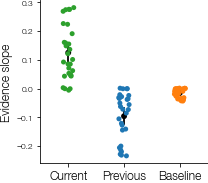

In [13]:
ml_slopes = pd.melt(
    slopes, 
    value_vars=['curr', 'prev', 'base'], 
    var_name='category', 
    value_name='slope',
)

fig, ax = plt.subplots(figsize=(3, 3))
g = sns.stripplot(
    data=ml_slopes, x='category', y='slope', palette=['C2', 'C0', 'C1'], ax=ax
)
g = sns.pointplot(
    data=ml_slopes, x='category', y='slope', color='k', join=False, ax=ax
)
g.set_xticklabels(['Current', 'Previous', 'Baseline'], fontsize='large')
g.set(xlabel='', ylabel='Evidence slope')
slopes.agg(['mean', 'sem'])
fig.savefig(fig_dir / 'evidence_slope_context.pdf')

## EEG decoding by train position

In [14]:
basename = 'logreg_pmvpa_r10_test8'
export_dir = cfr_dir / 'eeg' / 'study_patterns' / 'class' / basename
subjects, _ = task.get_subjects()
eeg = pd.concat(
    [
        pd.read_csv(
            export_dir / f'sub-{subject}_decode.csv', index_col=0
        ) for subject in subjects
    ], axis=0, ignore_index=True
)

In [15]:
merge_keys = ['subject', 'list', 'position', 'trial_type']
eeg_keys = merge_keys + ['cel', 'loc', 'obj']
results = pd.merge(study, eeg[eeg_keys], on=merge_keys, how='outer')

In [16]:
# get study events, excluding the first blocks where previous 
# and baseline categories are undefined
included = results.query('block > 1 and trial_type == "study"')

# reorganize classifier evidence by block category (curr, prev, base)
labeled = decode.label_evidence(included)
labeled['subject'] = included['subject']
labeled['block_pos'] = included['block_pos']

# get average evidence and event counts
block_pos = labeled.groupby(['subject', 'block_pos'])
m = block_pos[['curr', 'prev', 'base']].mean()
m['n'] = block_pos['curr'].count()
m.head(6)

curr      prev      base    n
subject block_pos                                   
1       1          0.422041  0.271517  0.245893  191
        2          0.463986  0.247055  0.235120  191
        3          0.484401  0.262119  0.233932  122
        4          0.435607  0.236626  0.278392   79
        5          0.447207  0.328904  0.176856   20
        6          0.464683  0.261168  0.212960   12

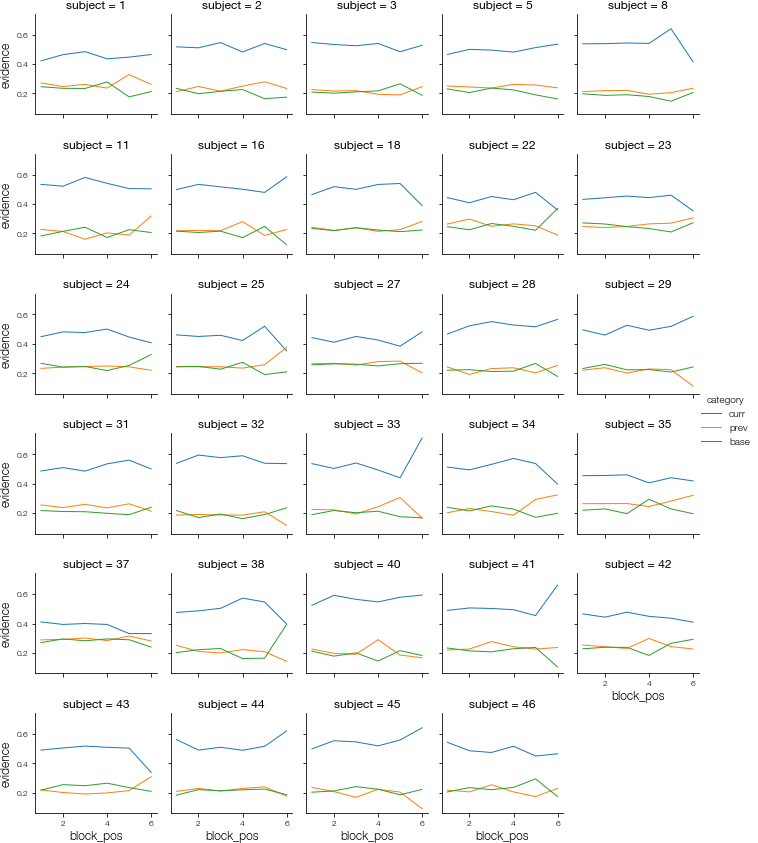

In [17]:
ml = pd.melt(
    m.reset_index(), 
    id_vars=['subject', 'block_pos'], 
    value_vars=['curr', 'prev', 'base'], 
    var_name='category', value_name='evidence',
)
sns.relplot(
    data=ml, 
    x='block_pos', 
    y='evidence', 
    hue='category', 
    col='subject', 
    col_wrap=5,
    kind='line',
    height=2,
);

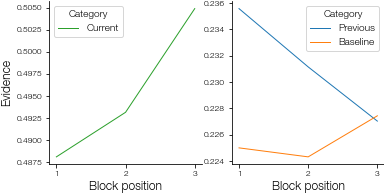

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ml['Category'] = ml['category'].map({'curr': 'Current', 'prev': 'Previous', 'base': 'Baseline'})
h = sns.lineplot(
    data=ml.query('category == "curr" and block_pos <= 3'), 
    x='block_pos', 
    y='evidence',
    hue='Category',
    palette=['C2'],
    ci=None,
    ax=ax[0]
)
sns.lineplot(
    data=ml.query('category != "curr" and block_pos <= 3'), 
    x='block_pos', 
    y='evidence',
    hue='Category',
    palette=['C0', 'C1'],
    ci=None,
    ax=ax[1]
)
# ax[0].legend()
ax[0].set(ylabel='Evidence', xlabel='Block position', xticks=[1, 2, 3])
ax[1].set(ylabel='', xlabel='Block position', xticks=[1, 2, 3]);
fig.savefig(fig_dir / 'evidence_block_eeg.pdf')

In [19]:
slopes = decode.regress_evidence_block_pos(m)

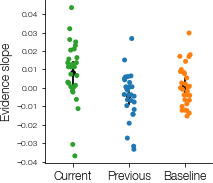

In [20]:
ml_slopes = pd.melt(
    slopes, 
    value_vars=['curr', 'prev', 'base'], 
    var_name='category', 
    value_name='slope',
)

fig, ax = plt.subplots(figsize=(3, 3))
g = sns.stripplot(
    data=ml_slopes, x='category', y='slope', palette=['C2', 'C0', 'C1'], ax=ax
)
g = sns.pointplot(
    data=ml_slopes, x='category', y='slope', color='k', join=False, ax=ax
)
g.set_xticklabels(['Current', 'Previous', 'Baseline'], fontsize='large')
g.set(xlabel='', ylabel='Evidence slope')
slopes.agg(['mean', 'sem'])
fig.savefig(fig_dir / 'evidence_slope_eeg.pdf')